# Data Prep for Regional Frequency Analysis

First load the data using pandas and create a time index so that we can use time-based functions for selecting data.
More on time series in pandas here: http://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html
Drop the old column and remove any missing values (NaN).

In [44]:
import pandas as pd
import numpy as np

data = pd.read_csv('1612340_19800101_20221231.csv')
st = data['datetime'].iloc[0]
st
data['datetime'] = pd.to_datetime(data['datetime'])
data.index = pd.DatetimeIndex(data.datetime)
data = data.drop(columns=['datetime']).dropna()
data

,hourly_height_STND_meters
datetime,
1980-01-01 00:00:00,1.500
1980-01-01 01:00:00,1.466
1980-01-01 02:00:00,1.405
1980-01-01 03:00:00,1.317
1980-01-01 04:00:00,1.250
...,...
2022-12-31 19:00:00,1.495
2022-12-31 20:00:00,1.511
2022-12-31 21:00:00,1.505


Select the minimum time for the start time.
Check for missing data.

In [2]:
st = data.index.min()
print(st)
SL = data['hourly_height_STND_meters']
SL

# remove missing values
#SL = data[~SL.isna()]

missing = data[SL.isna()]
missing
#missing.to_csv('missing_values.csv', index=False)

1980-01-01 00:00:00


,hourly_height_STND_meters
datetime,


This is an example of detrending the data in Python, but I don't think it's necessary for this.

<Axes: >

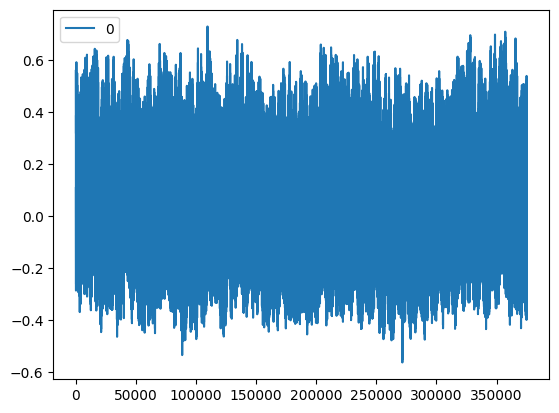

In [5]:
from scipy import signal

detrended = signal.detrend(SL)

detrended_df = pd.DataFrame(detrended)
detrended_df.plot()

The resample function in Python allows us to select the daily ('D') max for the dataset. This is possible because of the time index we created in step 1.
http://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#resampling

In [8]:
from datetime import timedelta

dailyMax = data.resample('D').max()

i = list(dailyMax['hourly_height_STND_meters'].items())[0]
i
dt = i[0]
m = i[1]

# filter down to 1 day
nearest = data.loc[dt:dt + timedelta(hours=23)]
nearest
# find the index of where the daily max is
sel = nearest[nearest['hourly_height_STND_meters'] == m]
sel
#data = data.drop(
b = data.loc[sel.index[0] - timedelta(hours=2): sel.index[0]-timedelta(hours=1)]
a = data.loc[sel.index[0]+timedelta(hours=1): sel.index[0]+timedelta(hours=2)]
c = pd.concat([b,a])
data = data.drop(c.index)
data.head(24)

#window = data['hourly_height_STND_meters'].rolling(5)
#cond = window == m
#idx = np.where(cond)[0]
#idx

,hourly_height_STND_meters
datetime,
1980-01-01 00:00:00,1.500
1980-01-01 01:00:00,1.466
1980-01-01 02:00:00,1.405
1980-01-01 03:00:00,1.317
1980-01-01 04:00:00,1.250
1980-01-01 05:00:00,1.201
1980-01-01 06:00:00,1.158
1980-01-01 07:00:00,1.189
1980-01-01 08:00:00,1.247


The FilterData function finds the max value within a window (r in the code).  the code first sorts the daily max values from highest to lowest.  it then iterates through the sorted daily max, keeping highest the daily max within the pre-determined window size and removing the other daily max values..  if r = 2, then it takes the highest daily max that is within +/- 2 days. (Ayesha Genz)

In [46]:
import math

drop = None
for dt, m in dailyMax['hourly_height_STND_meters'].items():
    if math.isnan(m):
        continue
    # filter down to 1 day
    nearest = data.loc[dt:dt + timedelta(hours=23)]
    # find the index of where the daily max is
    sel = nearest[nearest['hourly_height_STND_meters'] == m]
    b = data.loc[sel.index[0] - timedelta(hours=2): sel.index[0]-timedelta(hours=1)]
    a = data.loc[sel.index[0]+timedelta(hours=1): sel.index[0]+timedelta(hours=2)]            
    drop = pd.concat([drop,b,a])    
filtered = data.drop(drop.index)
filtered.head(25)

,hourly_height_STND_meters
datetime,
1980-01-01 00:00:00,1.500
1980-01-01 01:00:00,1.466
1980-01-01 02:00:00,1.405
1980-01-01 03:00:00,1.317
1980-01-01 04:00:00,1.250
1980-01-01 05:00:00,1.201
1980-01-01 06:00:00,1.158
1980-01-01 07:00:00,1.189
1980-01-01 08:00:00,1.247


Attempting to vectorize here. Not working yet.

In [ ]:
from datetime import datetime

def win(x):
    print(x)
    m = np.argmax(x) # index of max value

    sel = data.iloc[m]
    sel = sel.name

    b = data.loc[sel - timedelta(hours=2): sel-timedelta(hours=1)]
    a = data.loc[sel+timedelta(hours=1): sel+timedelta(hours=2)]
    c = pd.concat([b,a])    
    return 0

data.rolling('D').apply(win)

In [47]:
yrs = filtered.resample('Y').max()
yrs

,hourly_height_STND_meters
datetime,
1980-12-31,2.003
1981-12-31,2.039
1982-12-31,2.009
1983-12-31,2.015
1984-12-31,2.079
1985-12-31,2.033
1986-12-31,1.990
1987-12-31,2.070
1988-12-31,2.036


In [48]:
u = filtered.quantile(0.98)
excess = filtered[filtered['hourly_height_STND_meters'] > u[0]]
excess

,hourly_height_STND_meters
datetime,
1980-01-01 14:00:00,1.954
1980-01-02 14:00:00,1.923
1980-01-03 15:00:00,1.875
1980-01-08 18:00:00,1.832
1980-01-14 12:00:00,1.829
...,...
2022-12-24 13:00:00,1.843
2022-12-24 16:00:00,2.016
2022-12-25 16:00:00,1.969


In [11]:

#exceedance=excess[1]-u
#exceedance
#lambda_ = len(excess) / len(yrs)

/tmp/ipykernel_2543/3335478235.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  excess.rename(columns = {'hourly_height_STND_meters':'Filtered Data above threshold'}, inplace=True)


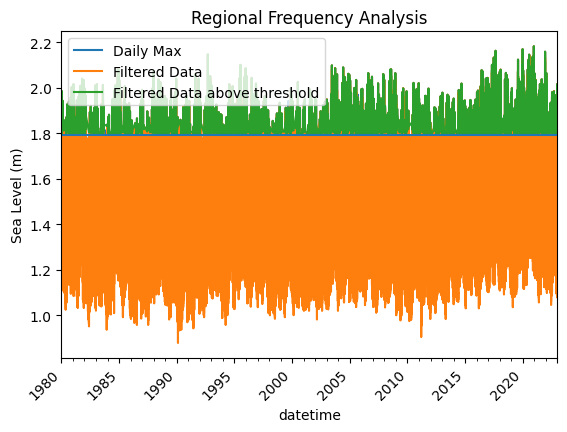

In [49]:
import matplotlib.pyplot as plt

# create a figure
fig, ax = plt.subplots()

# plot dailyMax
dailyMax.rename(columns = {'hourly_height_STND_meters':'Daily Max'}, inplace=True)
dailyMax.plot(ax=ax, title='Daily Max')
#ax.plot(dailyMax, '*-', label='Daily Max')

# plot daily_filtered
filtered.rename(columns = {'hourly_height_STND_meters':'Filtered Data'}, inplace=True)
filtered.plot(ax=ax, title='Filtered Data')
#ax.plot(data, '*', label='Filtered Data')

# plot excess
excess.rename(columns = {'hourly_height_STND_meters':'Filtered Data above threshold'}, inplace=True)
excess.plot(ax=ax, title='Filtered Data above threshold')
#ax.plot(excess, 'o', label='Filtered Data above threshold')

# plot 98th percentile threshold
ax.axhline(u[0], linewidth=1.5)
#v = ax.axis()
#ax.plot([v[0], v[1]], [u, u], 'k-', linewidth=1.5)

# add legend, ylabel, and datetick
ax.legend()
ax.set_ylabel('Sea Level (m)')
ax.set_title('Regional Frequency Analysis')
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.2)
plt.show()